<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week10/HAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import math
import os

In [8]:
# --- 1. 설정 및 데이터 전처리 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# !!! 경로 수정 !!!
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset'

# --- (추가) 하위 폴더 경로 설정 ---
TRAIN_PATH = os.path.join(DATA_PATH, 'train/')
TEST_PATH = os.path.join(DATA_PATH, 'test/')

# --- 데이터 로딩 함수 (공통) ---
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep=r'\s+')
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = os.path.join(prefix, group, 'Inertial Signals/')
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(os.path.join(prefix, group, 'y_'+group+'.txt'))
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix)
    testX, testy = load_dataset_group('test', prefix)
    trainy = trainy - 1
    testy = testy - 1
    print(f"trainX shape: {trainX.shape}, trainy shape: {trainy.shape}")
    print(f"testX shape: {testX.shape}, testy shape: {testy.shape}")
    return trainX, trainy, testX, testy


Using device: cuda


In [9]:
# --- 학습/평가 함수 (공통) ---
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc.item()

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc.item()

def get_test_results(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(6), yticklabels=range(6))
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [10]:
# --- 모델 1: Inception-Style CNN (Original) ---
class OriginalKerasCNN(nn.Module):
    def __init__(self, input_dim, output_dim, f1=128, f2=64, f3=32):
        super(OriginalKerasCNN, self).__init__()

        self.branch1_1 = nn.Conv1d(input_dim, f1, kernel_size=3)
        self.branch1_2 = nn.Conv1d(input_dim, f1, kernel_size=5)
        self.branch1_3 = nn.Conv1d(input_dim, f1, kernel_size=7)
        self.branch1_4 = nn.Conv1d(input_dim, f1, kernel_size=9)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=5)

        self.branch2_1 = nn.Conv1d(f1, f2, kernel_size=3)
        self.branch2_2 = nn.Conv1d(f1, f2, kernel_size=5)
        self.branch2_3 = nn.Conv1d(f1, f2, kernel_size=7)
        self.branch2_4 = nn.Conv1d(f1, f2, kernel_size=9)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=5)

        self.branch3_1 = nn.Conv1d(f2, f3, kernel_size=3)
        self.branch3_2 = nn.Conv1d(f2, f3, kernel_size=5)
        self.branch3_3 = nn.Conv1d(f2, f3, kernel_size=7)
        self.branch3_4 = nn.Conv1d(f2, f3, kernel_size=9)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=5)

        self.flatten = nn.Flatten()

        # Flattened: 55 * 32 = 1760 (Keras 모델과 동일)
        self.fc1 = nn.Linear(1760, 512)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(512, output_dim)

    def forward(self, x):
        x_permuted = x.permute(0, 2, 1) # (N, 9, 128)

        # Layer 1
        b1_1 = self.relu1(self.branch1_1(x_permuted)) # (N, 128, 126)
        b1_2 = self.relu1(self.branch1_2(x_permuted)) # (N, 128, 124)
        b1_3 = self.relu1(self.branch1_3(x_permuted)) # (N, 128, 122)
        b1_4 = self.relu1(self.branch1_4(x_permuted)) # (N, 128, 120)
        c1 = torch.cat([b1_1, b1_2, b1_3, b1_4], dim=2) # (N, 128, 492)
        p1 = self.pool1(c1) # (N, 128, 98)

        # Layer 2
        b2_1 = self.relu2(self.branch2_1(p1)) # (N, 64, 96)
        b2_2 = self.relu2(self.branch2_2(p1)) # (N, 64, 94)
        b2_3 = self.relu2(self.branch2_3(p1)) # (N, 64, 92)
        b2_4 = self.relu2(self.branch2_4(p1)) # (N, 64, 90)
        c2 = torch.cat([b2_1, b2_2, b2_3, b2_4], dim=2) # (N, 64, 372)
        p2 = self.pool2(c2) # (N, 64, 74)

        # Layer 3
        b3_1 = self.relu3(self.branch3_1(p2)) # (N, 32, 72)
        b3_2 = self.relu3(self.branch3_2(p2)) # (N, 32, 70)
        b3_3 = self.relu3(self.branch3_3(p2)) # (N, 32, 68)
        b3_4 = self.relu3(self.branch3_4(p2)) # (N, 32, 66)
        c3 = torch.cat([b3_1, b3_2, b3_3, b3_4], dim=2) # (N, 32, 276)
        p3 = self.pool3(c3) # (N, 32, 55)

        flat = self.flatten(p3) # (N, 1760)
        fc1_out = self.relu_fc(self.fc1(flat))
        out = self.fc2(fc1_out)
        return out

In [11]:
# --- 메인 실행 ---
def main():
    # 데이터 로드
    trainX, trainy, testX, testy = load_dataset(DATA_PATH)

    # Keras의 validation_split=0.1과 유사하게 0.1로 변경
    X_train, X_val, y_train, y_val = train_test_split(
        trainX, trainy, test_size=0.1, random_state=42, stratify=trainy
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.flatten(), dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.flatten(), dtype=torch.long)
    X_test_tensor = torch.tensor(testX, dtype=torch.float32)
    y_test_tensor = torch.tensor(testy.flatten(), dtype=torch.long)

    # 하이퍼파라미터
    N_EPOCHS = 40       # 40으로 증가
    LEARNING_RATE = 0.001
    BATCH_SIZE = 32     # 32로 변경

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    N_TIMESTEPS = X_train.shape[1]
    N_FEATURES = X_train.shape[2]
    N_OUTPUTS = len(np.unique(trainy))

    # 모델 1 실행
    model_name = "1. Inception-Style CNN (Original)"
    model = OriginalKerasCNN(N_FEATURES, N_OUTPUTS).to(device)

    # AdamW -> Adam으로 변경
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    criterion = nn.CrossEntropyLoss()

    print(f"\n--- 🏋️ Training {model_name} ---")

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1:02}/{N_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

    # 테스트셋 평가
    print(f"\n--- 📊 Evaluating {model_name} on Test Set ---")
    y_test_true, y_test_pred = get_test_results(model, test_loader, device)
    test_acc = accuracy_score(y_test_true, y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test_true, y_test_pred, digits=4, zero_division=0))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test_true, y_test_pred)
    print(cm)
    plot_confusion_matrix(cm, model_name)

trainX shape: (7352, 128, 9), trainy shape: (7352, 1)
testX shape: (2947, 128, 9), testy shape: (2947, 1)

--- 🏋️ Training 1. Inception-Style CNN (Original) ---
Epoch 01/40 | Train Loss: 0.3980 | Train Acc: 0.8284 | Val Loss: 0.1126 | Val Acc: 0.9484
Epoch 02/40 | Train Loss: 0.1335 | Train Acc: 0.9451 | Val Loss: 0.0942 | Val Acc: 0.9660
Epoch 03/40 | Train Loss: 0.1179 | Train Acc: 0.9492 | Val Loss: 0.1054 | Val Acc: 0.9633
Epoch 04/40 | Train Loss: 0.1069 | Train Acc: 0.9537 | Val Loss: 0.0876 | Val Acc: 0.9620
Epoch 05/40 | Train Loss: 0.0967 | Train Acc: 0.9578 | Val Loss: 0.0723 | Val Acc: 0.9701
Epoch 06/40 | Train Loss: 0.1053 | Train Acc: 0.9560 | Val Loss: 0.0713 | Val Acc: 0.9633
Epoch 07/40 | Train Loss: 0.0798 | Train Acc: 0.9640 | Val Loss: 0.0634 | Val Acc: 0.9688
Epoch 08/40 | Train Loss: 0.0757 | Train Acc: 0.9672 | Val Loss: 0.0586 | Val Acc: 0.9728
Epoch 09/40 | Train Loss: 0.0794 | Train Acc: 0.9677 | Val Loss: 0.0567 | Val Acc: 0.9674
Epoch 10/40 | Train Loss: 0.0

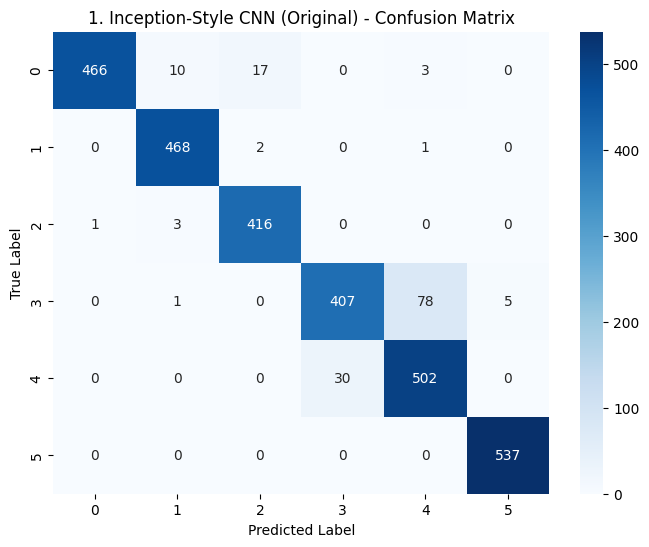

In [12]:
if __name__ == "__main__":
    # 데이터셋 경로가 올바른지 확인
    if not os.path.isdir(DATA_PATH) or not os.path.isdir(TRAIN_PATH) or not os.path.isdir(TEST_PATH):
        print(f"Error: DATA_PATH '{DATA_PATH}'를 찾을 수 없습니다.")
        print("DATA_PATH 변수를 'UCI HAR Dataset' 폴더의 실제 경로로 수정해주세요.")
    else:
        main()